# This notebook was created to explore contrast-enhancement.
- I got the idea from the paper, "Segmentation of vessels in angiograms using convolutional neural networks"
    - E. Nasr-Esfahania, et al, 2017 (this was one we discussed months ago)
    - The paper has 2 CNNs, and prior to feeding the CNNs, the images are enhanced with tophat operations

### Here is the relevant text from section 2.1, contrast
- In white top-hat the areas in the image that have high gray scalevalues, i.e. bright areas, are tracked and intensified. In contrast, inblack top-hat the dark regions in the image are highlighted. Henceby applying Eq. (1), after the image is added by white top-hat andthe black top-hat is subtracted from the image, the contrast of theimage is increased.
- fen = f + fw − fb
- In multi scale top-hat transform, different scales are selected for structuring element Bi. 
- Using Eqs. (2) and (3) to correspondingblack and white top-hat maps are calculated for each scale.
- (2) fwi=f− ((fBi) ⊕ Bi) 
- (3)fbi= ((f⊕Bi)  Bi) − f 

- In Eqs. (2) and (3), Bi, f, fwiand fbidenote the structuring ele-ment of the ithscale, input image, the white and black top-hattransforms respectively. Also, ⊕,  are morphological dilation anderosion operators. 
- The dilation and erosion of f(x, y)by Bi(u, v)aredefined by Eqs. (4) and (5).

- (4) f⊕Bi =maxu,v (f (x−u, y−v) +Bi (u, v)) 
- (5) fBi =minu,v (f (x+u, y+v) −Bi (u, v))


In [1]:
import numpy as np
from data_loader import *
import cv2
import skimage
from skimage import morphology
from skimage import filters
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\Dan\Anaconda3\envs\mcenv\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [2]:
data, filenames = load_train_test_images(cv=0, stage=1)
        
#
#   Unpack Images from data; all in (n x c x h x w) format
#
train_x_imgs = data["train_x_images"]
train_y_imgs = data["train_y_images"]
test_x_imgs = data["test_x_images"]
test_y_imgs = data["test_y_images"]
train_filenames  = filenames["train_filenames"]
test_filenames = filenames["test_filenames"]

In [3]:
img = train_x_imgs[0]

# Subtracting black-tophat from white-tophat to enhance contrast
- Remember 'B' for Black tophat == Bottom-hat; white-tophat == top-hat

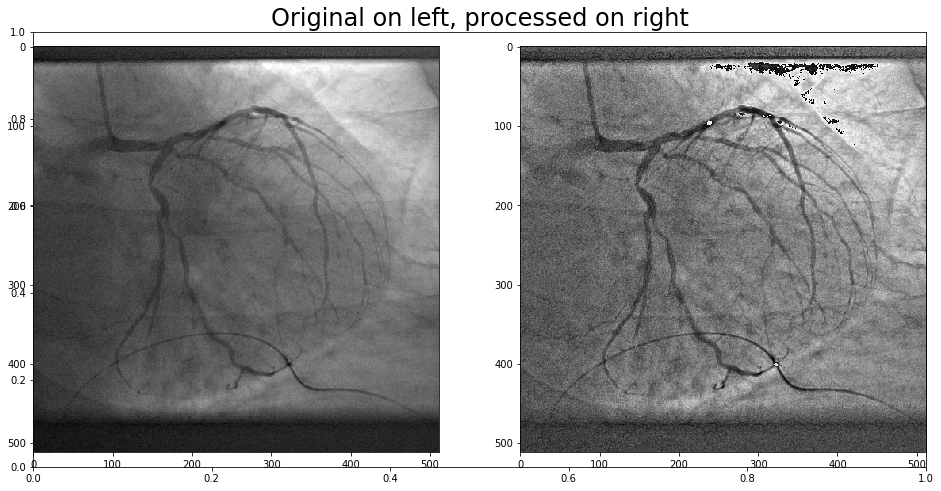

In [4]:
bottom_hat = morphology.black_tophat(np.squeeze(img), selem=morphology.square(20))
tophat = morphology.white_tophat(np.squeeze(img), selem=morphology.square(20))

newimg = img + tophat - bottom_hat

fig = plt.figure(figsize=(16,8));
plt.title("Original on left, processed on right", fontsize=24);
fig.add_subplot(121)
plt.imshow(np.squeeze(img), cmap='gray')
fig.add_subplot(122)
plt.imshow(np.squeeze(newimg), cmap='gray')

# Using multi-scale tophat transform
- take max pixel values from tophats with structuring elements of size 3, 

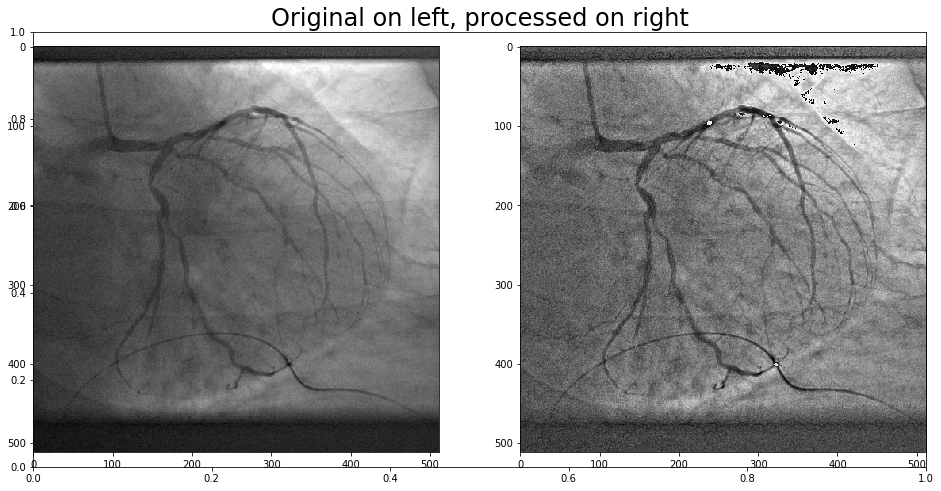

In [5]:
elems = [3, 7, 11, 15, 19]
bottom_hats = np.array([morphology.black_tophat(np.squeeze(img), selem=morphology.square(elem)) for elem in elems])
tophats = np.array([morphology.white_tophat(np.squeeze(img), selem=morphology.square(elem)) for elem in elems])

bottom_hat = bottom_hats.max(axis=0)
tophat = tophats.max(axis=0)

newimg = img + tophat - bottom_hat

bottom_hat = morphology.black_tophat(np.squeeze(img), selem=morphology.square(20))
tophat = morphology.white_tophat(np.squeeze(img), selem=morphology.square(20))

newimg = img + tophat - bottom_hat

fig = plt.figure(figsize=(16,8));
plt.title("Original on left, processed on right", fontsize=24);
fig.add_subplot(121)
plt.imshow(np.squeeze(img), cmap='gray')
fig.add_subplot(122)
plt.imshow(np.squeeze(newimg), cmap='gray')

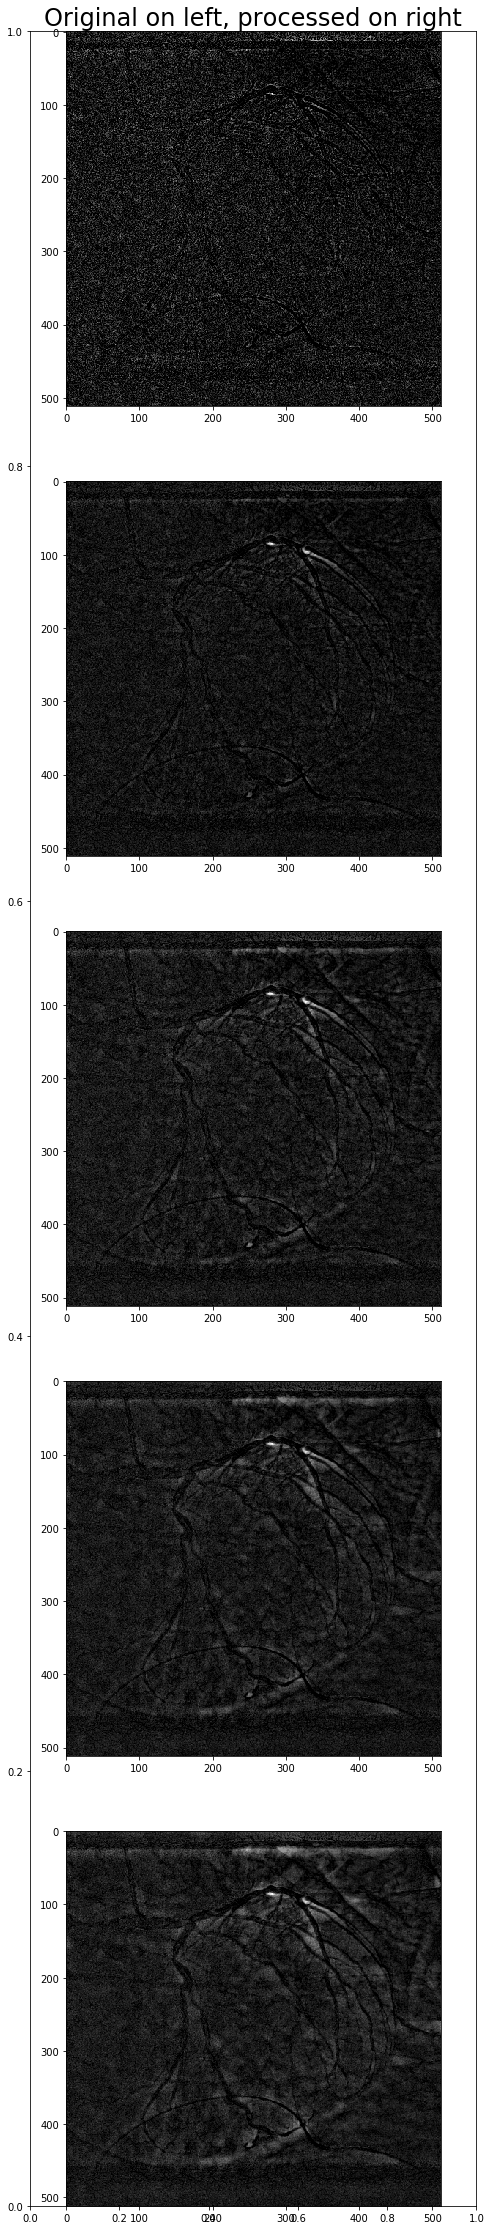

In [6]:
fig = plt.figure(figsize=(8,40));
plt.title("Original on left, processed on right", fontsize=24);
for i in range(len(tophats)):
    fig.add_subplot(5, 1, i+1)
    plt.imshow(np.squeeze(tophats[i]), cmap='gray')

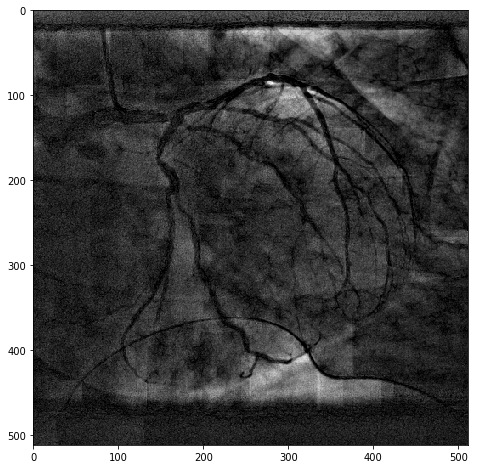

In [7]:
fig = plt.figure(figsize=(8,8));
t50=morphology.white_tophat(np.squeeze(img), selem=morphology.square(50))
plt.imshow(t50, cmap='gray')

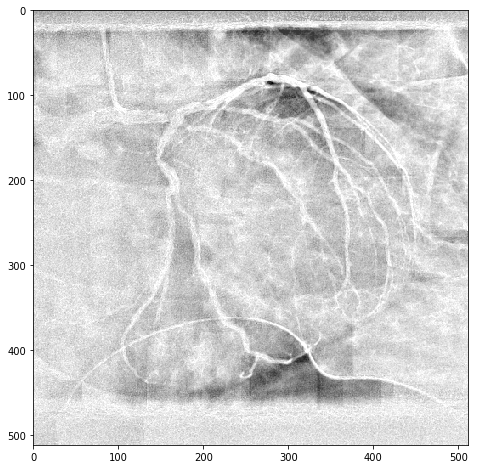

In [8]:
fig = plt.figure(figsize=(8,8));
plt.imshow(cv2.bitwise_not(t50), cmap='gray')

In [9]:
t50

array([[34, 30, 33, ..., 29, 20, 20],
       [28, 30, 32, ..., 25, 20, 25],
       [27, 34, 36, ..., 20, 18, 25],
       ...,
       [17, 16, 18, ..., 14, 14, 12],
       [18, 25, 19, ...,  5, 12,  8],
       [14,  9, 10, ...,  3, 14, 12]], dtype=uint8)

In [10]:
cv2.bitwise_not(t50)

array([[221, 225, 222, ..., 226, 235, 235],
       [227, 225, 223, ..., 230, 235, 230],
       [228, 221, 219, ..., 235, 237, 230],
       ...,
       [238, 239, 237, ..., 241, 241, 243],
       [237, 230, 236, ..., 250, 243, 247],
       [241, 246, 245, ..., 252, 241, 243]], dtype=uint8)

# "Blood vessel segmentation in coronary angiogram image" paper
### Steps:
1. The input coronary angiogram image is read.
2. For preprocessing morphological Top Hat operation is carried out on the input image.
3. Morphological Closing operation i.e. Dilation and erosion is applied on the image with disk shaped structuring elements.
4. The image obtained after morphological operation is then thresholded using Otsu’s thresholding .
5. After thresholding segmented image is obtained.

pred max: 255.00, min: 39.00


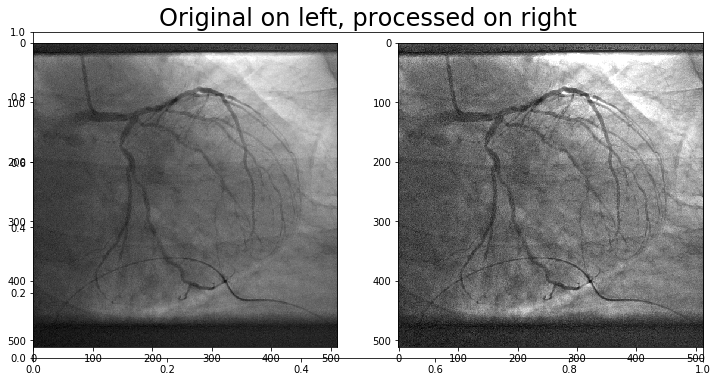

In [11]:
# Prevent overflow with np.int16
tophat = morphology.white_tophat(np.squeeze(img), selem=morphology.disk(18))
tophat = (np.squeeze(img.astype(np.int16))) + (tophat.astype(np.int16))
pred = np.where(tophat>255,255,tophat).astype(np.uint8)
print("pred max: %.02f, min: %.02f" % (pred.max(), pred.min()))
fig = plt.figure(figsize=(12,6));
plt.title("Original on left, processed on right", fontsize=24);
fig.add_subplot(121)
plt.imshow(np.squeeze(img), cmap='gray')
fig.add_subplot(122)
plt.imshow(np.squeeze(pred), cmap='gray')

In [12]:
close = morphology.closing(np.squeeze(pred), selem=morphology.disk(18))
close = (np.squeeze(pred.astype(np.int16))) - (close.astype(np.int16))

In [13]:
close = morphology.closing(np.squeeze(pred), selem=morphology.disk(18))
close = (np.squeeze(pred.astype(np.int16))) - (close.astype(np.int16))
print("close max: %.02f, min: %.02f" % (close.max(), close.min()))

close max: 0.00, min: -165.00


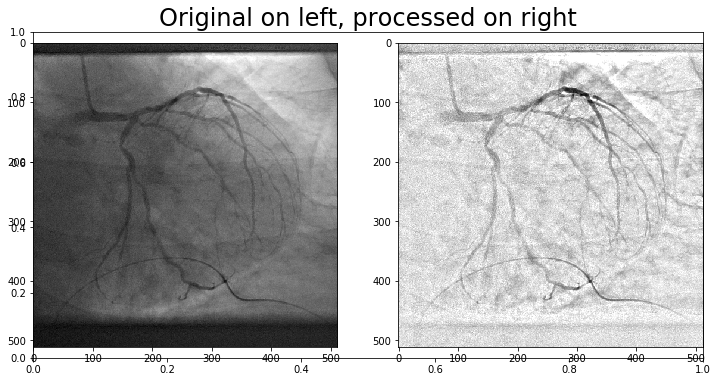

In [14]:
fig = plt.figure(figsize=(12,6));
plt.title("Original on left, processed on right", fontsize=24);
fig.add_subplot(121)
plt.imshow(np.squeeze(img), cmap='gray')
fig.add_subplot(122)
plt.imshow(np.squeeze(close), cmap='gray')

threshold: -32.00
pred max: 255.00, min: 0.00


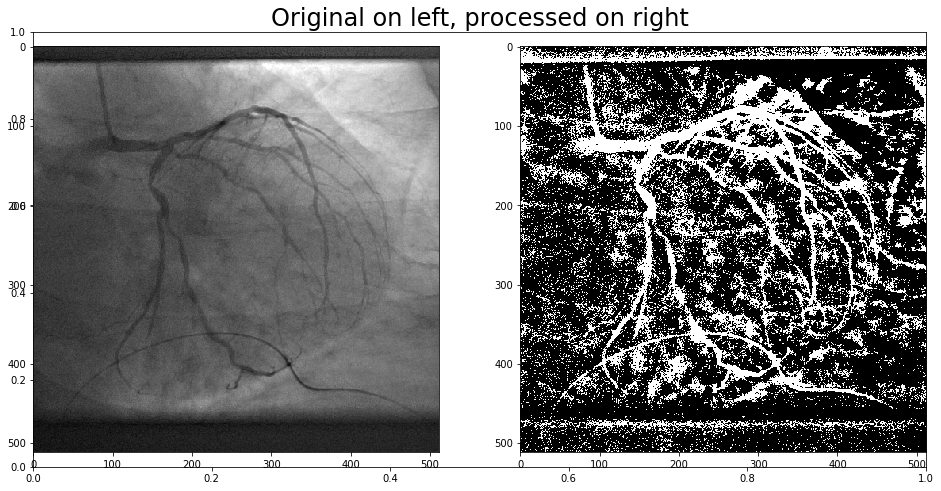

In [15]:
thresh = filters.threshold_otsu(close)
print("threshold: %.02f"%thresh)
pred=np.where(np.squeeze(close) < thresh, 255, 0)
print("pred max: %.02f, min: %.02f" % (pred.max(), pred.min()))

fig = plt.figure(figsize=(16,8));
plt.title("Original on left, processed on right", fontsize=24);
fig.add_subplot(121)
plt.imshow(np.squeeze(img), cmap='gray')
fig.add_subplot(122)
plt.imshow(np.squeeze(pred), cmap='gray')

# All together now

In [16]:
allimgs= np.vstack([data["train_x_images"] , data["test_x_images"]])
allfnames = filenames["train_filenames"]+ filenames["test_filenames"]
allimgs.shape, len(allfnames)

((119, 1, 512, 512), 119)

In [ ]:
# Prevent overflow with np.int16
disksize=22
for i in range(len(allfnames)):
    img = allimgs[i].copy()
    name = allfnames[i]
    #label = train_y_imgs[i].copy()
    
    tophat = morphology.white_tophat(np.squeeze(img), selem=morphology.disk(disksize))
    tophat = (np.squeeze(img.astype(np.int16))) + (tophat.astype(np.int16))
    
    pred=cv2.normalize(tophat,None,0,255,cv2.NORM_MINMAX)
    
    print("pred max: %.02f, min: %.02f, range: %.02f" % (pred.max(), pred.min(), pred.max()-pred.min()))
    #pred = np.where(tophat>255,255,tophat).astype(np.uint8)
    
    close = morphology.closing(np.squeeze(pred), selem=morphology.disk(disksize))
    close = (np.squeeze(pred.astype(np.int16))) - (close.astype(np.int16))
    
    close=cv2.normalize(close,None,0,-255,cv2.NORM_MINMAX)
    print("close max: %.02f, min: %.02f, range: %.02f" % (close.max(), close.min(), close.max()-close.min()))
    
    thresh = 1.0 * filters.threshold_otsu(close)
    print("threshold: %.02f"%thresh)
    
    pred=np.where(np.squeeze(close) < thresh, 255, 0)
    
    """
    fig = plt.figure(figsize=(18,6));
    plt.title("Original on left, label in middle, processed on right", fontsize=24);
    fig.add_subplot(121)
    plt.imshow(np.squeeze(img), cmap='gray')
    fig.add_subplot(132)
    plt.imshow(np.squeeze(label), cmap='gray')
    fig.add_subplot(133)
    plt.imshow(np.squeeze(pred), cmap='gray')
    """
    
    #plt.imsave("..\\..\\..\\..\\Data\\Vessels\\tophat\\" + name, pred, cmap='gray')

# More attempts - trying to follow the instruction on the paper

159 75


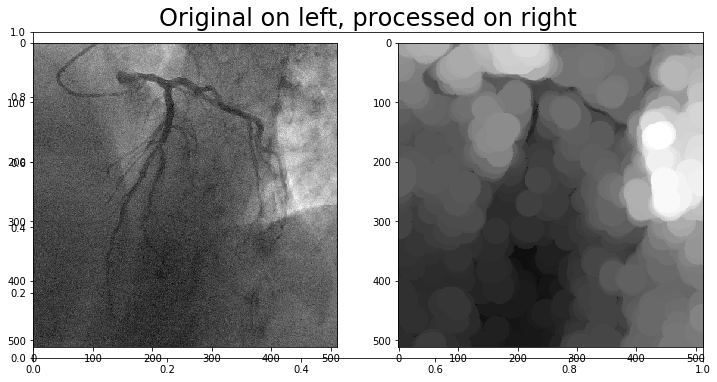

In [18]:
disksize = 22
img = np.squeeze(train_x_imgs[-1].copy())
label = train_y_imgs[-1].copy()
# Preprocess
tophat = morphology.white_tophat(np.squeeze(img), selem=morphology.disk(disksize))
tophat = img-tophat
print(tophat.max(), tophat.min())
fig = plt.figure(figsize=(12,6));
plt.title("Original on left, processed on right", fontsize=24);
fig.add_subplot(121)
plt.imshow(np.squeeze(img), cmap='gray')
fig.add_subplot(122)
plt.imshow(np.squeeze(tophat), cmap='gray')

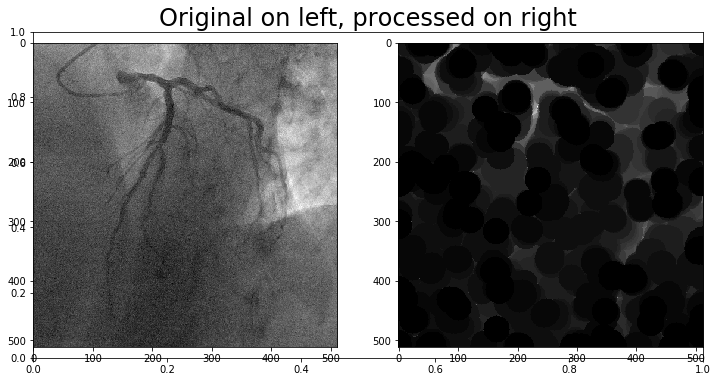

In [19]:
tophat = morphology.white_tophat(np.squeeze(cv2.bitwise_not(tophat)), selem=morphology.disk(disksize))
close = morphology.closing(np.squeeze(tophat), selem=morphology.disk(disksize))

fig = plt.figure(figsize=(12,6));
plt.title("Original on left, processed on right", fontsize=24);
fig.add_subplot(121)
plt.imshow(np.squeeze(img), cmap='gray')
fig.add_subplot(122)
plt.imshow(np.squeeze(close), cmap='gray')

threshold: -3.00
close max: 0.00, min: -13.00, range: 13.00


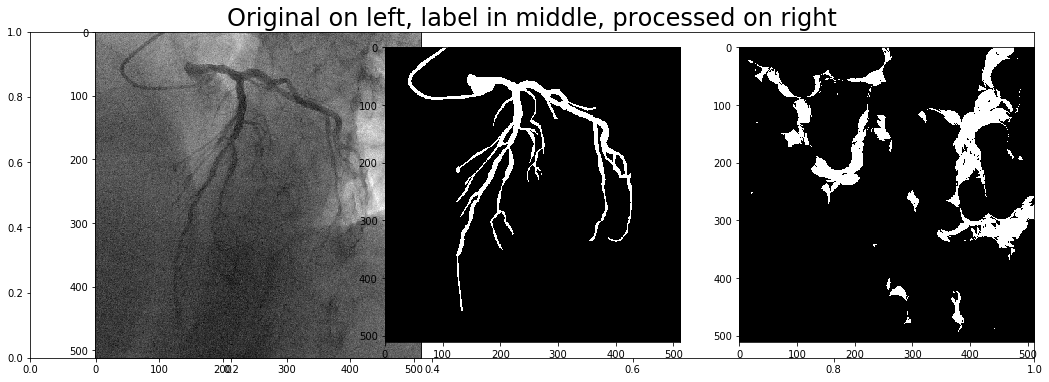

In [20]:
#pred = np.where(tophat>255,255,tophat).astype(np.uint8)
pred=tophat

close = morphology.closing(np.squeeze(pred), selem=morphology.disk(disksize))
close = (np.squeeze(pred.astype(np.int16))) - (close.astype(np.int16))
thresh = filters.threshold_otsu(close)
print("threshold: %.02f"%thresh)
print("close max: %.02f, min: %.02f, range: %.02f" % (close.max(), close.min(), close.max()-close.min()))

pred=np.where(np.squeeze(close) < thresh, 255, 0)


fig = plt.figure(figsize=(18,6));
plt.title("Original on left, label in middle, processed on right", fontsize=24);
fig.add_subplot(121)
plt.imshow(np.squeeze(img), cmap='gray')
fig.add_subplot(132)
plt.imshow(np.squeeze(label), cmap='gray')
fig.add_subplot(133)
plt.imshow(np.squeeze(pred), cmap='gray')

# More attempts - try to run process twice on image

pred max: 255.00, min: 0.00, range: 255.00
close max: 0.00, min: -255.00, range: 255.00
threshold: -56.00


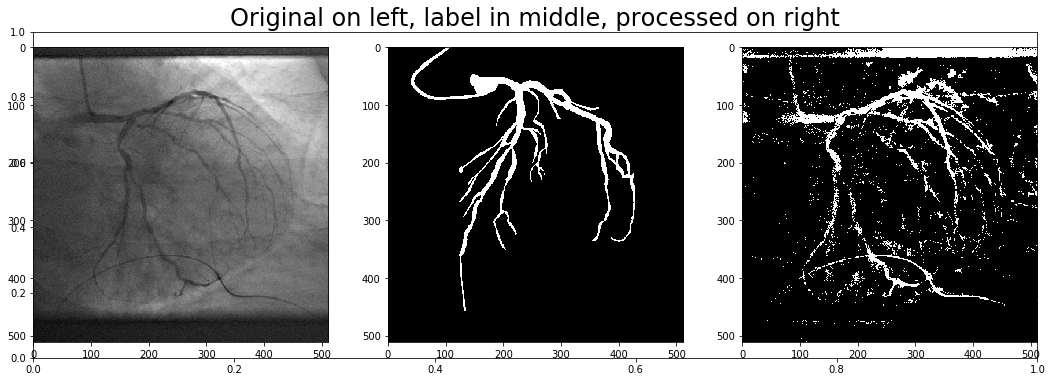

In [21]:
img = allimgs[0].copy()
name = allfnames[0]
#label = train_y_imgs[i].copy()

tophat = morphology.white_tophat(np.squeeze(img), selem=morphology.disk(disksize))
tophat = (np.squeeze(img.astype(np.int16))) + (tophat.astype(np.int16))

pred=cv2.normalize(tophat,None,0,255,cv2.NORM_MINMAX)

print("pred max: %.02f, min: %.02f, range: %.02f" % (pred.max(), pred.min(), pred.max()-pred.min()))
#pred = np.where(tophat>255,255,tophat).astype(np.uint8)

close = morphology.closing(np.squeeze(pred), selem=morphology.disk(disksize))
close = (np.squeeze(pred.astype(np.int16))) - (close.astype(np.int16))

close=cv2.normalize(close,None,0,-255,cv2.NORM_MINMAX)
print("close max: %.02f, min: %.02f, range: %.02f" % (close.max(), close.min(), close.max()-close.min()))

thresh = 1.0 * filters.threshold_otsu(close)
print("threshold: %.02f"%thresh)

pred=np.where(np.squeeze(close) < thresh, 255, 0)

fig = plt.figure(figsize=(18,6));
plt.title("Original on left, label in middle, processed on right", fontsize=24);
fig.add_subplot(131)
plt.imshow(np.squeeze(img), cmap='gray')
fig.add_subplot(132)
plt.imshow(np.squeeze(label), cmap='gray')
fig.add_subplot(133)
plt.imshow(np.squeeze(pred), cmap='gray')


255 0


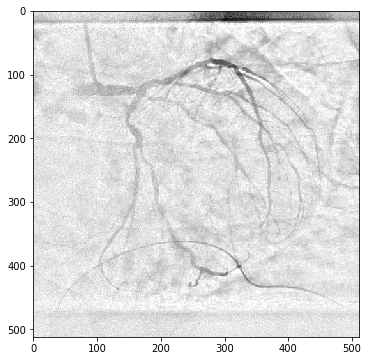

In [22]:
fig = plt.figure(figsize=(6,6));
saveclose=cv2.normalize(close,None,0,255,cv2.NORM_MINMAX).astype(np.uint8)
print(saveclose.max(), saveclose.min())
plt.imshow(close, cmap='gray')

255 0


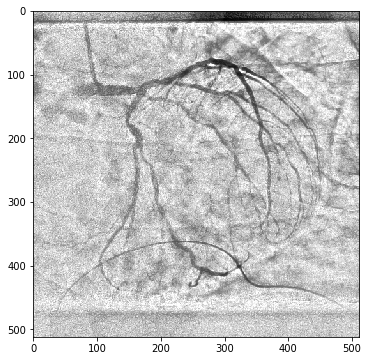

In [23]:
test = skimage.exposure.equalize_adapthist(saveclose)
fig = plt.figure(figsize=(6,6));
test=cv2.normalize(test,None,0,255,cv2.NORM_MINMAX).astype(np.uint8)
print(test.max(), test.min())
plt.imshow(test, cmap='gray')

threshold: 176.00


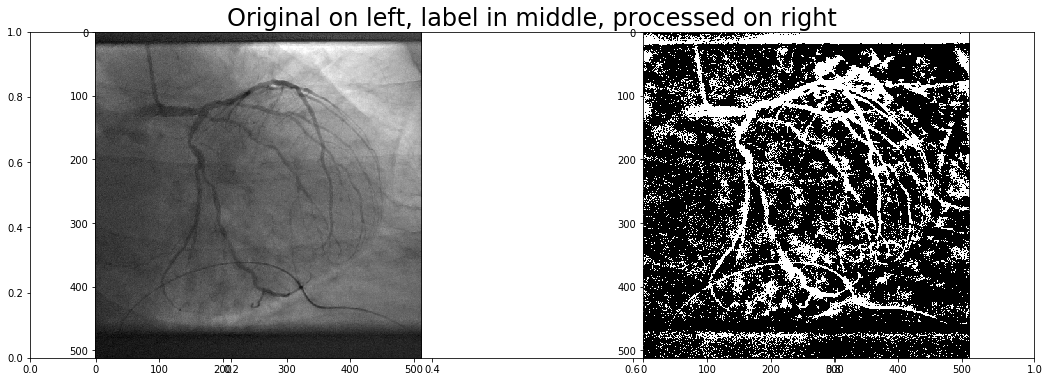

In [24]:
thresh = 1.0 * filters.threshold_otsu(test)
print("threshold: %.02f"%thresh)

pred=np.where(np.squeeze(test) < thresh, 255, 0)

fig = plt.figure(figsize=(18,6));
plt.title("Original on left, label in middle, processed on right", fontsize=24);
fig.add_subplot(121)
plt.imshow(np.squeeze(img), cmap='gray')
fig.add_subplot(122)
plt.imshow(np.squeeze(pred), cmap='gray')


255 0


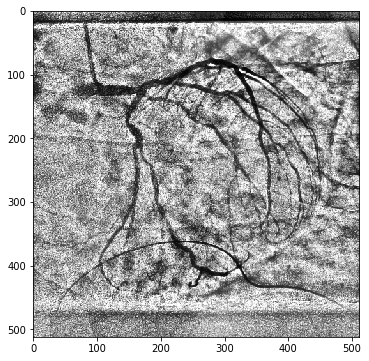

In [25]:
test2 = skimage.exposure.equalize_adapthist(test)
fig = plt.figure(figsize=(6,6));
test2=cv2.normalize(test2,None,0,255,cv2.NORM_MINMAX).astype(np.uint8)
print(test2.max(), test2.min())
plt.imshow(test2, cmap='gray')

threshold: 144.00


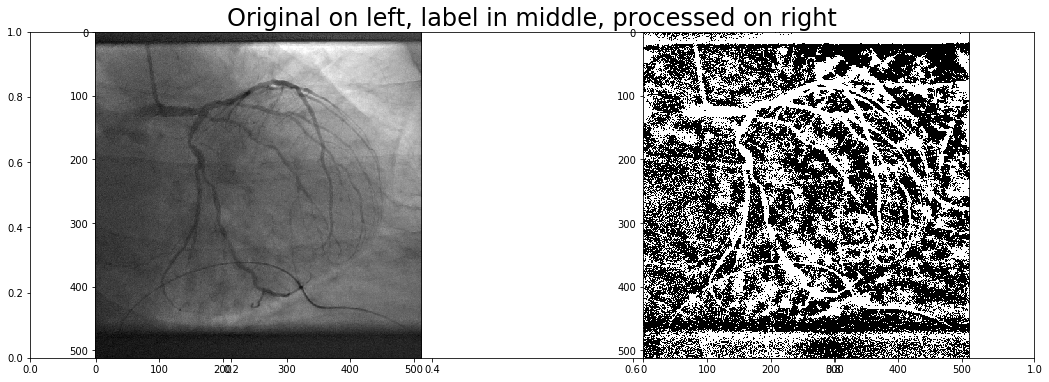

In [26]:
thresh = 1.0 * filters.threshold_otsu(test2)
print("threshold: %.02f"%thresh)

pred=np.where(np.squeeze(test2) < thresh, 255, 0)

fig = plt.figure(figsize=(18,6));
plt.title("Original on left, label in middle, processed on right", fontsize=24);
fig.add_subplot(121)
plt.imshow(np.squeeze(img), cmap='gray')
fig.add_subplot(122)
plt.imshow(np.squeeze(pred), cmap='gray')


255 0


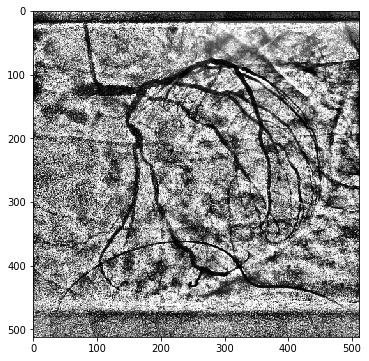

In [27]:
test3 = skimage.exposure.equalize_adapthist(test2)
fig = plt.figure(figsize=(6,6));
test3=cv2.normalize(test3,None,0,255,cv2.NORM_MINMAX).astype(np.uint8)
print(test3.max(), test3.min())
plt.imshow(test3, cmap='gray')

pred max: 255.00, min: 0.00, range: 255.00
close max: 0.00, min: -255.00, range: 255.00
threshold: -57.00


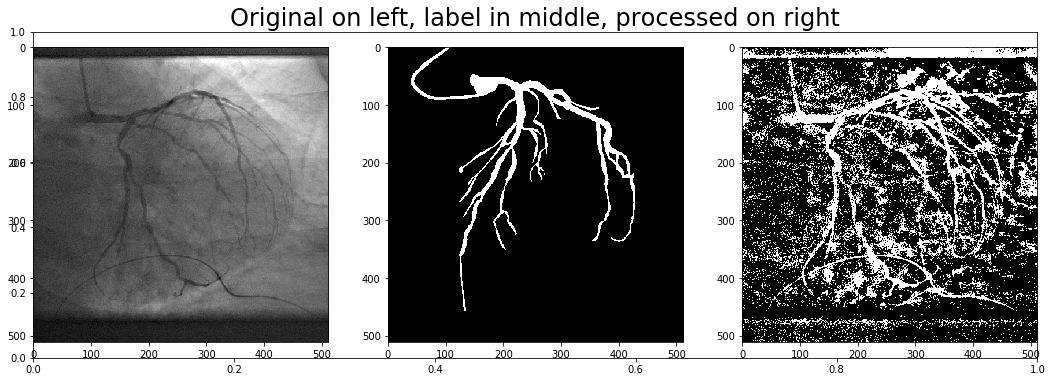

In [28]:
tophat = morphology.white_tophat(np.squeeze(saveclose), selem=morphology.disk(disksize))
tophat = (np.squeeze(saveclose.astype(np.int16))) + (tophat.astype(np.int16))

pred=cv2.normalize(tophat,None,0,255,cv2.NORM_MINMAX)

print("pred max: %.02f, min: %.02f, range: %.02f" % (pred.max(), pred.min(), pred.max()-pred.min()))
#pred = np.where(tophat>255,255,tophat).astype(np.uint8)

close = morphology.closing(np.squeeze(pred), selem=morphology.disk(disksize))
close = (np.squeeze(pred.astype(np.int16))) - (close.astype(np.int16))

close=cv2.normalize(close,None,0,-255,cv2.NORM_MINMAX)
print("close max: %.02f, min: %.02f, range: %.02f" % (close.max(), close.min(), close.max()-close.min()))

thresh = 1.0 * filters.threshold_otsu(close)
print("threshold: %.02f"%thresh)

pred=np.where(np.squeeze(close) < thresh, 255, 0)

fig = plt.figure(figsize=(18,6));
plt.title("Original on left, label in middle, processed on right", fontsize=24);
fig.add_subplot(131)
plt.imshow(np.squeeze(img), cmap='gray')
fig.add_subplot(132)
plt.imshow(np.squeeze(label), cmap='gray')
fig.add_subplot(133)
plt.imshow(np.squeeze(pred), cmap='gray')

In [29]:
allimgs= np.vstack([data["train_x_images"] , data["test_x_images"]])
allfnames = filenames["train_filenames"]+ filenames["test_filenames"]
allimgs.shape, len(allfnames)

((119, 1, 512, 512), 119)

pred max: 255.00, min: 0.00, range: 255.00
close max: 255.00, min: 0.00, range: 255.00
threshold: 54.00


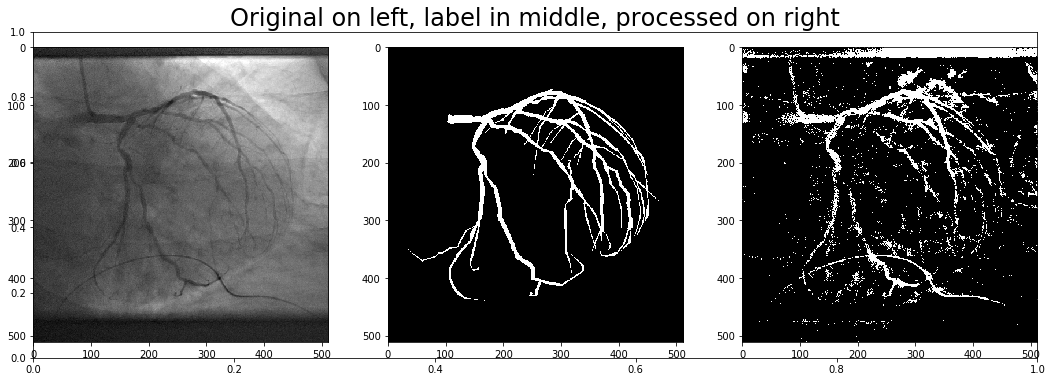

In [30]:
# Prevent overflow with np.int16
disksize=22
for i in range(1):
    img = allimgs[i].copy()
    name = allfnames[i]
    label = train_y_imgs[i].copy()
    
    tophat = morphology.white_tophat(np.squeeze(img), selem=morphology.disk(disksize))
    tophat = (np.squeeze(img.astype(np.int16))) + (tophat.astype(np.int16))
    
    pred=cv2.normalize(tophat,None,0,255,cv2.NORM_MINMAX)
    
    print("pred max: %.02f, min: %.02f, range: %.02f" % (pred.max(), pred.min(), pred.max()-pred.min()))
    #pred = np.where(tophat>255,255,tophat).astype(np.uint8)
    
    close = morphology.black_tophat(np.squeeze(pred), selem=morphology.disk(disksize))
    #close = (np.squeeze(pred.astype(np.int16))) - (close.astype(np.int16))
    
    close=cv2.normalize(close,None,0,255,cv2.NORM_MINMAX)
    print("close max: %.02f, min: %.02f, range: %.02f" % (close.max(), close.min(), close.max()-close.min()))
    
    thresh = 1.0 * filters.threshold_otsu(close)
    print("threshold: %.02f"%thresh)
    
    pred=np.where(np.squeeze(close) > thresh, 255, 0)
    
    
    fig = plt.figure(figsize=(18,6));
    plt.title("Original on left, label in middle, processed on right", fontsize=24);
    fig.add_subplot(131)
    plt.imshow(np.squeeze(img), cmap='gray')
    fig.add_subplot(132)
    plt.imshow(np.squeeze(label), cmap='gray')
    fig.add_subplot(133)
    plt.imshow(np.squeeze(pred), cmap='gray')
    

pred max: 255.00, min: 0.00, range: 255.00
new tophat pred max: 255.00, min: 0.00, range: 255.00
close max: 255.00, min: 0.00, range: 255.00
threshold: 133.00
23_LCA_RAO


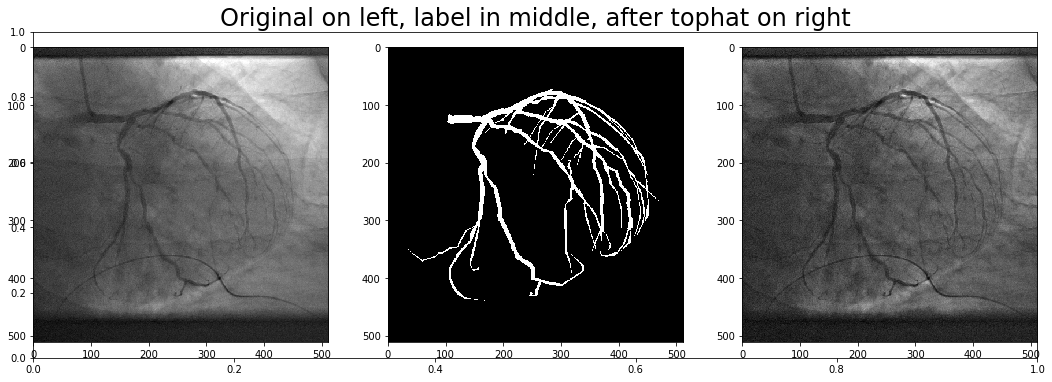

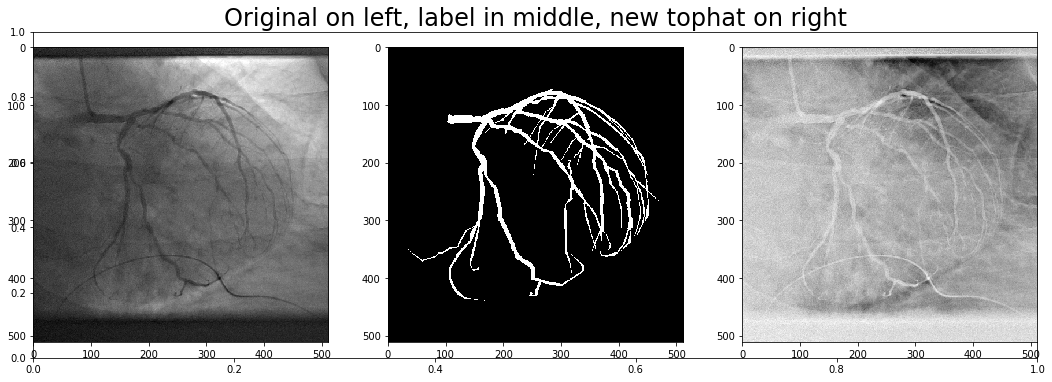

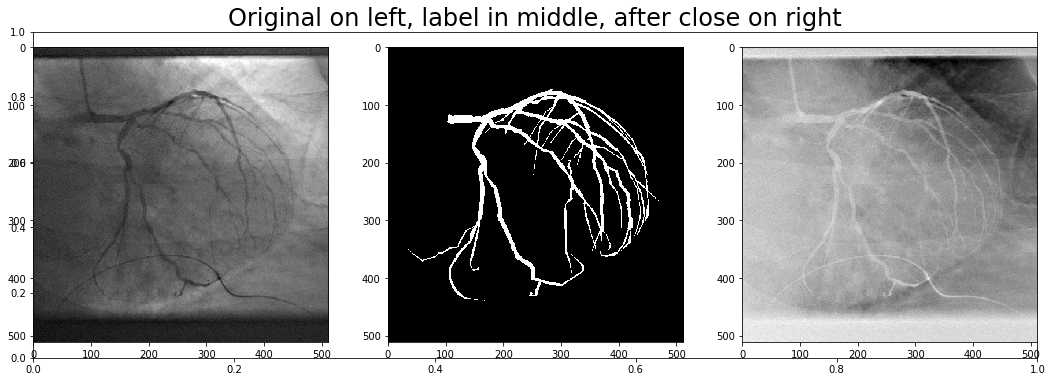

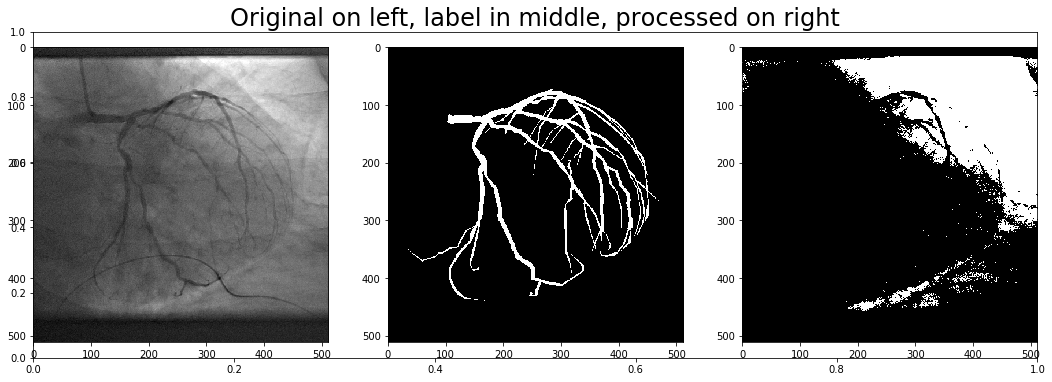

In [31]:
# Prevent overflow with np.int16
disksize=22
for i in range(1):
    img = allimgs[i].copy()
    name = allfnames[i]
    label = train_y_imgs[i].copy()
    
    tophat = morphology.white_tophat(np.squeeze(img), selem=morphology.disk(disksize))
    tophat = (np.squeeze(img.astype(np.int16))) + (tophat.astype(np.int16))
    
    preprocess=cv2.normalize(tophat,None,0,255,cv2.NORM_MINMAX)
    
    fig = plt.figure(figsize=(18,6));
    plt.title("Original on left, label in middle, after tophat on right", fontsize=24);
    fig.add_subplot(131)
    plt.imshow(np.squeeze(img), cmap='gray')
    fig.add_subplot(132)
    plt.imshow(np.squeeze(label), cmap='gray')
    fig.add_subplot(133)
    plt.imshow(np.squeeze(preprocess), cmap='gray')
    
    print("pred max: %.02f, min: %.02f, range: %.02f" % (pred.max(), pred.min(), pred.max()-pred.min()))
    #pred = np.where(tophat>255,255,tophat).astype(np.uint8)
    
    # Reverse and tophat again
    #pred = cv2.bitwise_not(preprocess.copy())
    pred = 255 - preprocess
    tophat = morphology.white_tophat(np.squeeze(pred), selem=morphology.disk(disksize))
    tophat = (np.squeeze(pred.astype(np.int16))) + (tophat.astype(np.int16)) - preprocess
    
    fig = plt.figure(figsize=(18,6));
    plt.title("Original on left, label in middle, new tophat on right", fontsize=24);
    fig.add_subplot(131)
    plt.imshow(np.squeeze(img), cmap='gray')
    fig.add_subplot(132)
    plt.imshow(np.squeeze(label), cmap='gray')
    fig.add_subplot(133)
    plt.imshow(np.squeeze(pred), cmap='gray')
    
    print("new tophat pred max: %.02f, min: %.02f, range: %.02f" % (pred.max(), pred.min(), pred.max()-pred.min()))
    #pred = np.where(tophat>255,255,tophat).astype(np.uint8)
    
    close = morphology.closing(np.squeeze(pred), selem=morphology.disk(disksize))
    close = (np.squeeze(pred.astype(np.int16))) + (close.astype(np.int16))
    
    close=cv2.normalize(close,None,0,255,cv2.NORM_MINMAX)
    print("close max: %.02f, min: %.02f, range: %.02f" % (close.max(), close.min(), close.max()-close.min()))
    
    fig = plt.figure(figsize=(18,6));
    plt.title("Original on left, label in middle, after close on right", fontsize=24);
    fig.add_subplot(131)
    plt.imshow(np.squeeze(img), cmap='gray')
    fig.add_subplot(132)
    plt.imshow(np.squeeze(label), cmap='gray')
    fig.add_subplot(133)
    plt.imshow(np.squeeze(close), cmap='gray')
    
    thresh = 1.0 * filters.threshold_otsu(close)
    print("threshold: %.02f"%thresh)
    print(allfnames[i])
    
    pred=np.where(np.squeeze(close) < thresh, 255, 0)
    
    
    fig = plt.figure(figsize=(18,6));
    plt.title("Original on left, label in middle, processed on right", fontsize=24);
    fig.add_subplot(131)
    plt.imshow(np.squeeze(img), cmap='gray')
    fig.add_subplot(132)
    plt.imshow(np.squeeze(label), cmap='gray')
    fig.add_subplot(133)
    plt.imshow(np.squeeze(pred), cmap='gray')
    

In [32]:
#fig = plt.figure(figsize=(18,6));
##plt.title("pred on left, denoise bilateral center, tf chambolle on right", fontsize=24);
#fig.add_subplot(131)
#plt.imshow(np.squeeze(pred), cmap='gray')
#fig.add_subplot(132)
#plt.imshow(np.squeeze(skimage.restoration.denoise_bilateral(pred, sigma_color=0.05, sigma_spatial=15, multichannel=False)), cmap='gray')
#fig.add_subplot(133)
#plt.imshow(np.squeeze(skimage.restoration.denoise_tv_chambolle(pred, weight=0.2, multichannel=False)), cmap='gray')

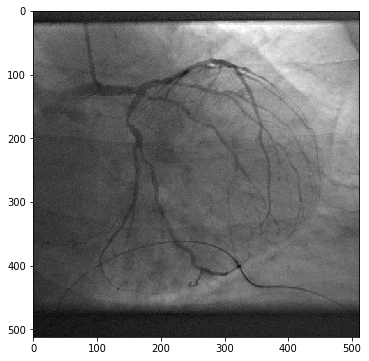

In [33]:
fig = plt.figure(figsize=(6,6));
plt.imshow(cv2.bitwise_not(np.squeeze(close)), cmap='gray')

In [34]:
train_filenames[0]

'23_LCA_RAO'